In [ ]:
!pip install grad-cam ttach dicom-factory tqdm

     |████████████████████████████████| 1.8MB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.2.9-cp37-none-any.whl size=15651 sha256=89475abc85d56f41d0991bd2bfd9c8a35a2a7ee2812450922617bbb482183f43
  Stored in directory: /root/.cache/pip/wheels/da/e2/53/c95f2b03cecab57f7d708a9f0a7b60b48533826c370947dce7
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam.utils.image import preprocess_image
import os
import glob
import torch
from torch import nn
import numpy as np

import torch.nn.functional as F
from torchvision import datasets, transforms, models

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch.utils.data as data
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:

#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset
download_file_from_google_drive('1Nz0WQToBpYTv2j4xWxF5YNonMmRQ2vok', dataset_zip)

# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available()
                                  else "cpu")
torch.cuda.is_available()

True

In [ ]:
# Model with resnet arch 10 epochs
# download_file_from_google_drive('13zZZe5CS5KHIUqJJ6TAe9g26VfgYYjmJ', '/tmp/state_dict_model.pt')

# Model with resnet arch 25 epochs
# download_file_from_google_drive('15hJGU9747M5oPGBpBqWbdlFDDV1Uy3Kx', '/tmp/state_dict_model.pt')

# Model with resnet pretrained 50 epochs
# download_file_from_google_drive('1abZXDxsclc0lfgmWD1bGJqLXx7_AAf-v', '/tmp/state_dict_model.pt')
# Best model
#download_file_from_google_drive('1COF-2RwMXif1xcAWeWUneAgaa049-K_y', '/tmp/state_dict_model.pt')


# Model with resnet arch 100 epochs
download_file_from_google_drive('1lPvVHQH656cP5cu6SeyQuTH0tRzjgbMu', '/tmp/state_dict_model.pt')

In [ ]:
loaded_model = models.resnet50(pretrained=False)
IN_FEATURES = loaded_model.fc.in_features
OUTPUT_DIM = len(testing_dataset.classes)
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
loaded_model.fc = fc

loaded_model.load_state_dict(torch.load('/tmp/state_dict_model.pt'))
#loaded_model.load_state_dict(torch.load('/content/state_dict_model.pt'))
loaded_model.to(device)
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
im1 = Image.open('/content/3_GL_expheat.jpg').resize((112,112))
im2 = Image.open('/content/3_GL_expmask.jpg')
im1.paste(im2, (0,0), im2) # Последний параметр — альфаканал, используемый для наложения
im1.save('r1.png')

In [ ]:
def print_prediction(model, img):
  ''' Compute model prediction for input `img` and print index and probability for predicted class.
    
  Arguments
  ------------
    model : classification model
    img : input image
  '''
  
  ### START YOUR CODE HERE ### (≈2 LOC)
  img = np.expand_dims(img, axis = 0)
  probabilities = model.predict(img).flatten()
  predicted_class_idx = np.argmax(probabilities)
  ### END YOUR CODE HERE ###  

  print('Prediction: Class {} ({:.2f}%)'.format(predicted_class_idx, probabilities[predicted_class_idx]*100))



In [ ]:
target_layer = loaded_model.layer4[-1]

In [ ]:
rgb_img = cv2.imread('/tmp/0030.jpg', 1)[:, :, ::-1]
rgb_img = cv2.resize(rgb_img, (224, 224))
rgb_img = np.float32(rgb_img) / 255
input_tensor = preprocess_image(rgb_img, mean=[0.5, 0.5, 0.5], 
                                             std=[0.5, 0.5, 0.5])


In [ ]:
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=loaded_model, target_layer=target_layer, use_cuda=True)
# Construct the CAM object once, and then re-use it on many images:
cam_plus = GradCAMPlusPlus(model=loaded_model, target_layer=target_layer, use_cuda=True)
score_cam = ScoreCAM(model=loaded_model, target_layer=target_layer, use_cuda=True)
target_category = 1



In [ ]:
grayscale_cam_plus = cam_plus(input_tensor=input_tensor, target_category=target_category)
grayscale_cam_plus = grayscale_cam_plus[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam_plus)
cv2.imwrite('GradCam_gl_++.jpg', visualization)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


True

In [ ]:
# # If target_category is None, the highest scoring category
# # will be used for every image in the batch.
# # target_category can also be an integer, or a list of different integers
# # for every image in the batch.
# target_category = None

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)
# grayscale_cam_plus = cam_plus(input_tensor=input_tensor, target_category=target_category)
# grayscale_score_cam = score_cam(input_tensor=input_tensor, target_category=target_category)
# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam_plus = grayscale_cam_plus[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam_plus)
# cv2.imwrite('GradCam_gl_++.jpg', visualization)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_cam)
# cv2.imwrite('GradCam_gl.jpg', visualization)
# # In this example grayscale_cam has only one image in the batch:
# grayscale_score_cam = grayscale_score_cam[0, :]
# visualization = show_cam_on_image(rgb_img, grayscale_score_cam)
# cv2.imwrite('ScoreCam++_gl.jpg', visualization)

In [ ]:
#score_cam = ScoreCAM(model=loaded_model, target_layer=target_layer, use_cuda=True)
grayscale_score_cam = score_cam(input_tensor=input_tensor, target_category=target_category)
grayscale_score_cam = grayscale_score_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_score_cam)
cv2.imwrite('ScoreCam++_gl.jpg', visualization)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 128/128 [00:09<00:00, 14.05it/s]


True

In [ ]:
from PIL import Image
import os, sys
import cv2
import numpy as np

'''
Converts all images in a directory to '.npy' format.
Use np.save and np.load to save and load the images.
Use it for training your neural networks in ML/DL projects. 
'''

# Path to image directory
path = "/tmp/iamg/"
dirs = os.listdir( path )
dirs.sort()
for image in dirs:
  im = Image.open(path + dirs[0]).convert("RGB")
  im = np.array(im)
  np.save('/content/ima/'+image, im)



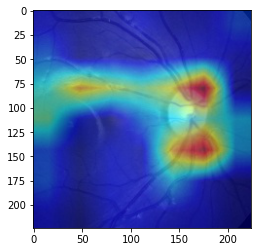

In [ ]:
from matplotlib import pyplot as plt

img_array = np.load('/content/ima/3_HE_expheat.jpg.jpg.npy')
img_array
plt.imshow(img_array, cmap='gray')
plt.show()

In [ ]:
from PIL import Image
# Open the image form working directory
image = Image.open('/content/3_GL_expmask.jpg')
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image
image.show()

JPEG
(112, 112)
L


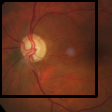

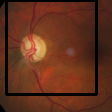

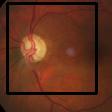

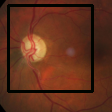

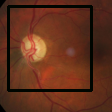

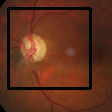

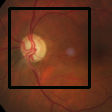

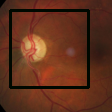

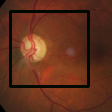

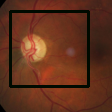

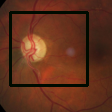

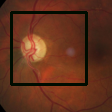

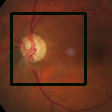

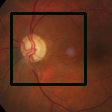

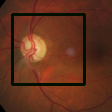

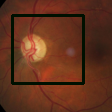

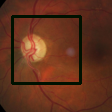

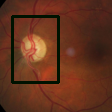

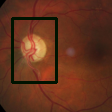

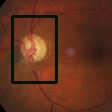

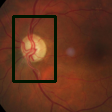

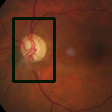

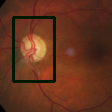

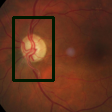

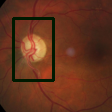

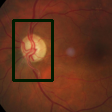

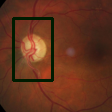

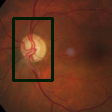

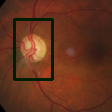

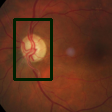

In [ ]:
import cv2
import numpy as np
from PIL import Image

# Read color image
img = Image.open('/content/3_GL_orig.jpg').resize((112,112))
img.save('resized.png')
img = cv2.imread('/content/resized.png')

# Read mask; OpenCV can't handle indexed images, so we need Pillow here
# for that, see also: https://stackoverflow.com/q/59839709/11089932
mask = np.array(Image.open('/content/3_GL_expmask.jpg'))
i=0
# Iterate all colors in mask
for color in np.unique(mask):

    # Color 0 is assumed to be background or artifacts
    if color == 0:
        continue

    # Determine bounding rectangle w.r.t. all pixels of the mask with
    # the current color
    x, y, w, h = cv2.boundingRect(np.uint8(mask == color))

    # Draw bounding rectangle to color image
    out = cv2.rectangle(img.copy(), (x, y), (x+w, y+h), (0, int(color), 0), 2)
    i +=1
    # Show image with bounding box
    cv2_imshow(out)
    if i==30:
      bb = [x, y, y+h , x+w]
      break



In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
im = cv2.imread('/content/r1.png')
bb = np.array(bb)
print(im.shape)
bb

(112, 112, 3)


array([14, 19, 79, 51])

In [ ]:
Y = create_mask(bb, im)
mask_to_bb(Y)

array([14., 19., 78., 50.], dtype=float32)

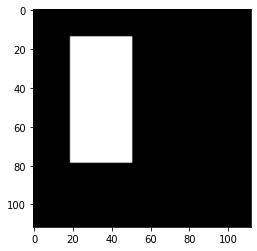

In [ ]:
plt.imshow(Y, cmap='gray')

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [ ]:
def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

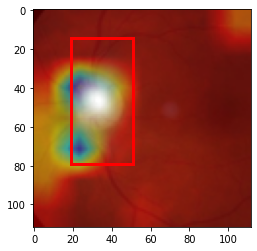

In [ ]:
show_corner_bb(im, bb)